In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving Coorti 2016-2018 estrazione 2020 02 21 per AI.xlsx to Coorti 2016-2018 estrazione 2020 02 21 per AI.xlsx
Saving esami coorti 2016-2018 - 2020 02 21 per AI.xlsx to esami coorti 2016-2018 - 2020 02 21 per AI.xlsx
User uploaded file "Coorti 2016-2018 estrazione 2020 02 21 per AI.xlsx" with length 6481955 bytes
User uploaded file "esami coorti 2016-2018 - 2020 02 21 per AI.xlsx" with length 15391182 bytes


In [ ]:
import pandas as pd
import numpy as np

#Read dataset
features =  pd.read_excel("Coorti 2016-2018 estrazione 2020 02 21 per AI.xlsx")
esami = pd.read_excel("esami coorti 2016-2018 - 2020 02 21 per AI.xlsx")

Siamo interessati al totale dei CFU ottenuti e la media dei voti ottenuti

In [ ]:
esami = esami.drop('Cod.Orientamento', axis=1)
esami = esami.drop('Cod.Indirizzo', axis=1)
esami = esami.drop('Cod.Materia', axis=1)
esami = esami.drop('Materia', axis=1)
esami = esami.drop('Giorno_esame', axis=1)

Calcoliamo la somma dei CFU per ogni studente la mergiamo con i dati di ogni studente e i valori NaN dei CFU verranno rimpiazzati con 0

In [ ]:
tot_cfu = esami.groupby('ID_Studente')['CFUsuperati'].sum()
features = features.merge(tot_cfu,how='outer', on='ID_Studente')
features['CFUsuperati'] = features['CFUsuperati'].fillna(0)

Calcoliamo la media di voti per ogni studente e la mergiamo con i dati di ogni studente e i valori NaN dei voti verranno rimpiazzati con 0

In [ ]:
esami = esami.drop('CFUsuperati', axis=1)
esami = esami.dropna()
media_voti = esami.groupby('ID_Studente')['Voto_se_numerico'].mean()
features = features.merge(media_voti,how='outer', on='ID_Studente')
features['Voto_se_numerico'] = features['Voto_se_numerico'].fillna(0)

Rimpiazziamo i codici relativi a determinate feature con i nomi delle feature, così da poter utilizzare la funzione get_dummies() ed ottenere un one-hot-encoding

In [ ]:
features["Diploma_scuola_superiore"] = features["Diploma_scuola_superiore"].map({1: "Classico", 2: "Scientifico", 3: "Linguistico", 4: "Magistrale", 5: "Artistico", 6: "Tecnico", 7: "Professionale", 8: "Altro_italiano", 9: "Estero", 99: "Non_disponibile"})
features["area_geografica_scuolasuperiore"] = features["area_geografica_scuolasuperiore"].map({1: "Emilia_romagna", 2: "Nord", 3: "Centro", 4: "Sud_isole", 5: "Estero", 99: "Non_disponibile"})
features["area_geografica_residenza"] = features["area_geografica_residenza"].map({1: "Emilia_romagna", 2: "Nord", 3: "Centro", 4: "Sud_isole", 5: "Estero", 99: "Non_disponibile"})
features["Ambito"] = features["Ambito"].map({1: "Economia", 2: "Farmacia", 3: "Giurisprudenza", 4: "Ingegneria", 5: "Lingue", 6: "Medicina", 7: "Veterinaria", 8: "Psicologia", 9: "Scienze", 10: "Scienze_agroalimanetari", 11: "Scienze_educazione_formazione", 12: "Scienze_motorie", 13: "Scienze_politiche", 14: "Scienze_statistiche", 15: "Sociologia", 16: "Studi_umanistici"})
features = pd.get_dummies(features)

In [ ]:
from datetime import datetime, date

def getAge(dataNascita, coorte):
    ts = pd.to_datetime(str(dataNascita)) 
    born = ts.strftime('%d/%m/%Y')
    born = datetime.strptime(born, "%d/%m/%Y").date()
    date = "31/12/"+str(coorte)
    dataAttuale = datetime.strptime(date, "%d/%m/%Y").date()
    age = dataAttuale.year - born.year - ((dataAttuale.month, dataAttuale.day) < (born.month, born.day))
    return age

#add new column with NaN
features["Eta"] = np.nan

for ind in features.index:
    studente = features.loc[ind]
    dataNascita = studente["DataNascita"]
    coorte = studente["Coorte"]
    #fill the new column with age 
    features.at[ind,'Eta'] = getAge(dataNascita, coorte)



Abbiamo sostituito i valori NaN della feature "voto_scuola_superiore" con la media.


Inoltre sono state droppate le colonne non utili ai fini dell'addestramento, ed infine eliminate le tuple contente almeno un NaN

In [ ]:
mean_value = features['voto_scuola_superiore'].mean()
features['voto_scuola_superiore'] = features['voto_scuola_superiore'].fillna(mean_value)
features= features.drop('ID_Studente', axis = 1)
features= features.drop('Classe_ISEE', axis = 1)
features= features.drop('DataNascita', axis = 1)
features = features.drop('Coorte', axis = 1)
features = features.dropna()

##Bilanciamento 1

Abbiamo bilanciato il dataset con approccio downsampling pareggiando il numero di dropout e non droput

In [ ]:
#Data preprocessing
dropout = pd.DataFrame()
noDropout = pd.DataFrame()

for ind in features.index:
    studente = pd.DataFrame(features.loc[[ind]])
    if features["Abbandoni"][ind] == 1:
        dropout = pd.concat([studente, dropout], ignore_index=True, axis = 0)
    else:
        noDropout = pd.concat([studente, noDropout], ignore_index=True, axis = 0)

#Bilanciamento dataset
final = pd.DataFrame()
for ind in dropout.index:
    studente_drop = pd.DataFrame(dropout.loc[[ind]])
    studente_noDrop = pd.DataFrame(noDropout.loc[[ind]])
    final = pd.concat([studente_drop, final], ignore_index=True, axis = 0)
    final = pd.concat([studente_noDrop, final], ignore_index=True, axis = 0)

print(len(final))
#Dividing the data into attributes and labels
X = final.drop('Abbandoni', axis=1)
y = final['Abbandoni']

##Bilanciamento 2

In [10]:
#Dividing the data into attributes and labels
X = features.drop('Abbandoni', axis=1)
y = features['Abbandoni']

from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler

#Resampling data
rus = RandomUnderSampler(sampling_strategy = "majority", random_state=42)
X_res, y_res = rus.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

X = X_res
y = y_res

Resampled dataset shape Counter({0: 2093, 1: 2093})


# Algorithm

Split the training testing set with a 10 % size and print the dimension of the data splitted
Split arrays or matrices into random train and test subsets.

In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error,r2_score
from sklearn import metrics


X_train,X_test,Y_train,Y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape,X_test.shape,Y_train.shape,Y_test.shape

Build a model and fit it with training test

In [ ]:
model = linear_model.LogisticRegression(max_iter=4000)
model.fit(X_train,Y_train)

Predict a value in Y_pred using model defined previously

In [ ]:
Y_pred = model.predict(X_test)

#Evaluating

In [ ]:
print('Coefficients: ',model.coef_)
print('Intercept: ',model.intercept_)
print('Mean Squared Error :%.2f' % mean_squared_error(Y_test,Y_pred))
print('Coefficient of determination (R ^2): %.2f' % r2_score(Y_test,Y_pred))


Evaluating the algorithm

we compute the confusion matrix, but it can't operate with continuos value, we must convert in [0,1].we say that any value in Y_pred above (0.6,1) convert to 1 otherwise 0

In [ ]:
print("Evaluating the Algorithm:\n")
cf_matrix = metrics.confusion_matrix(Y_test,Y_pred)
print(cf_matrix)
print(metrics.classification_report(Y_test,Y_pred))


print("true negative",cf_matrix[0,0])
print("false negative",cf_matrix[1,0])
print("true positive",cf_matrix[1,1])
print("false positive",cf_matrix[0,1])

print("\nEvaluating Prediction Accuracy:\n")
print("Accuracy:", metrics.accuracy_score(Y_test, Y_pred))

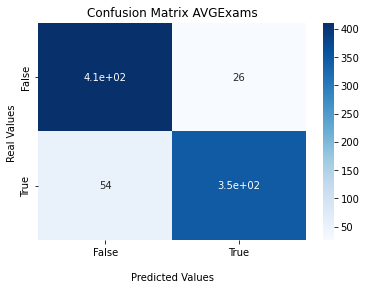

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix AVGExams');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Real Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()